# LSTM Autoencoder Anomaly Detection
## Communication error detection through **WMX time-series data**

**DC diff data gathered by the WMX ethercat master is used to detect anomalies in a time-series pattern.**

In this notebook, we'll build an *LSTM Autoencoder representation learning model*. (See the following example of the autoencoder model.)

<img src="https://lilianweng.github.io/posts/2018-08-12-vae/autoencoder-architecture.png" width="500">

You can find **excellent reference projects** that help you understand relevant concepts and techniques at the end of this notebook.

## Preparation
### Install neccesary Python libraries
Note that the Python environment where this notebook runs should already have **PyTorch** packages.

(To install **PyTorch**, go to https://pytorch.org/get-started/locally/)

In [ ]:
!pip install scipy
!pip install pandas
!pip install seaborn
!pip install -U scikit-learn
!pip install -q -U watermark
!pip install datasets
!pip install huggingface-hub
!pip install ipywidgets


### Versions of the installed packages

In [155]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,scipy

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.29.0

numpy : 2.0.1
pandas: 2.2.3
torch : 2.5.1
scipy : 1.14.1



### Import packages and initialize them

In [100]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from datasets import Dataset
from datasets import load_dataset
from huggingface_hub import login


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)

### Download the **normal** DC diff dataset from Hugging Face and load the dataset
Log in to the Hugging Face before downloading
(You may need a Hugging Face account to log in)


In [ ]:
# Login to the Hugging face
login()

In [101]:
# Load the normal dataset
dataset = load_dataset("Jake5/wmx_normal_data") 

hg_df = pd.DataFrame(dataset['train'])

print(f"Total Values: {hg_df.shape[0]}")
print(hg_df.head())

Total Values: 100047
                         Timestamp  DcDiffAvg
0 2024-11-01 04:13:46.454280+09:00     780472
1 2024-11-01 04:13:46.584383+09:00     783309
2 2024-11-01 04:13:46.693861+09:00     785026
3 2024-11-01 04:13:46.803610+09:00     786223
4 2024-11-01 04:13:46.913217+09:00     787620


### Check if CUDA is available and use the CUDA available device

In [102]:
print(f"CUDA available={torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA available=True


## Exploratory Data Analysis

Text(0.5, 1.0, 'DcDiff Normal Data')

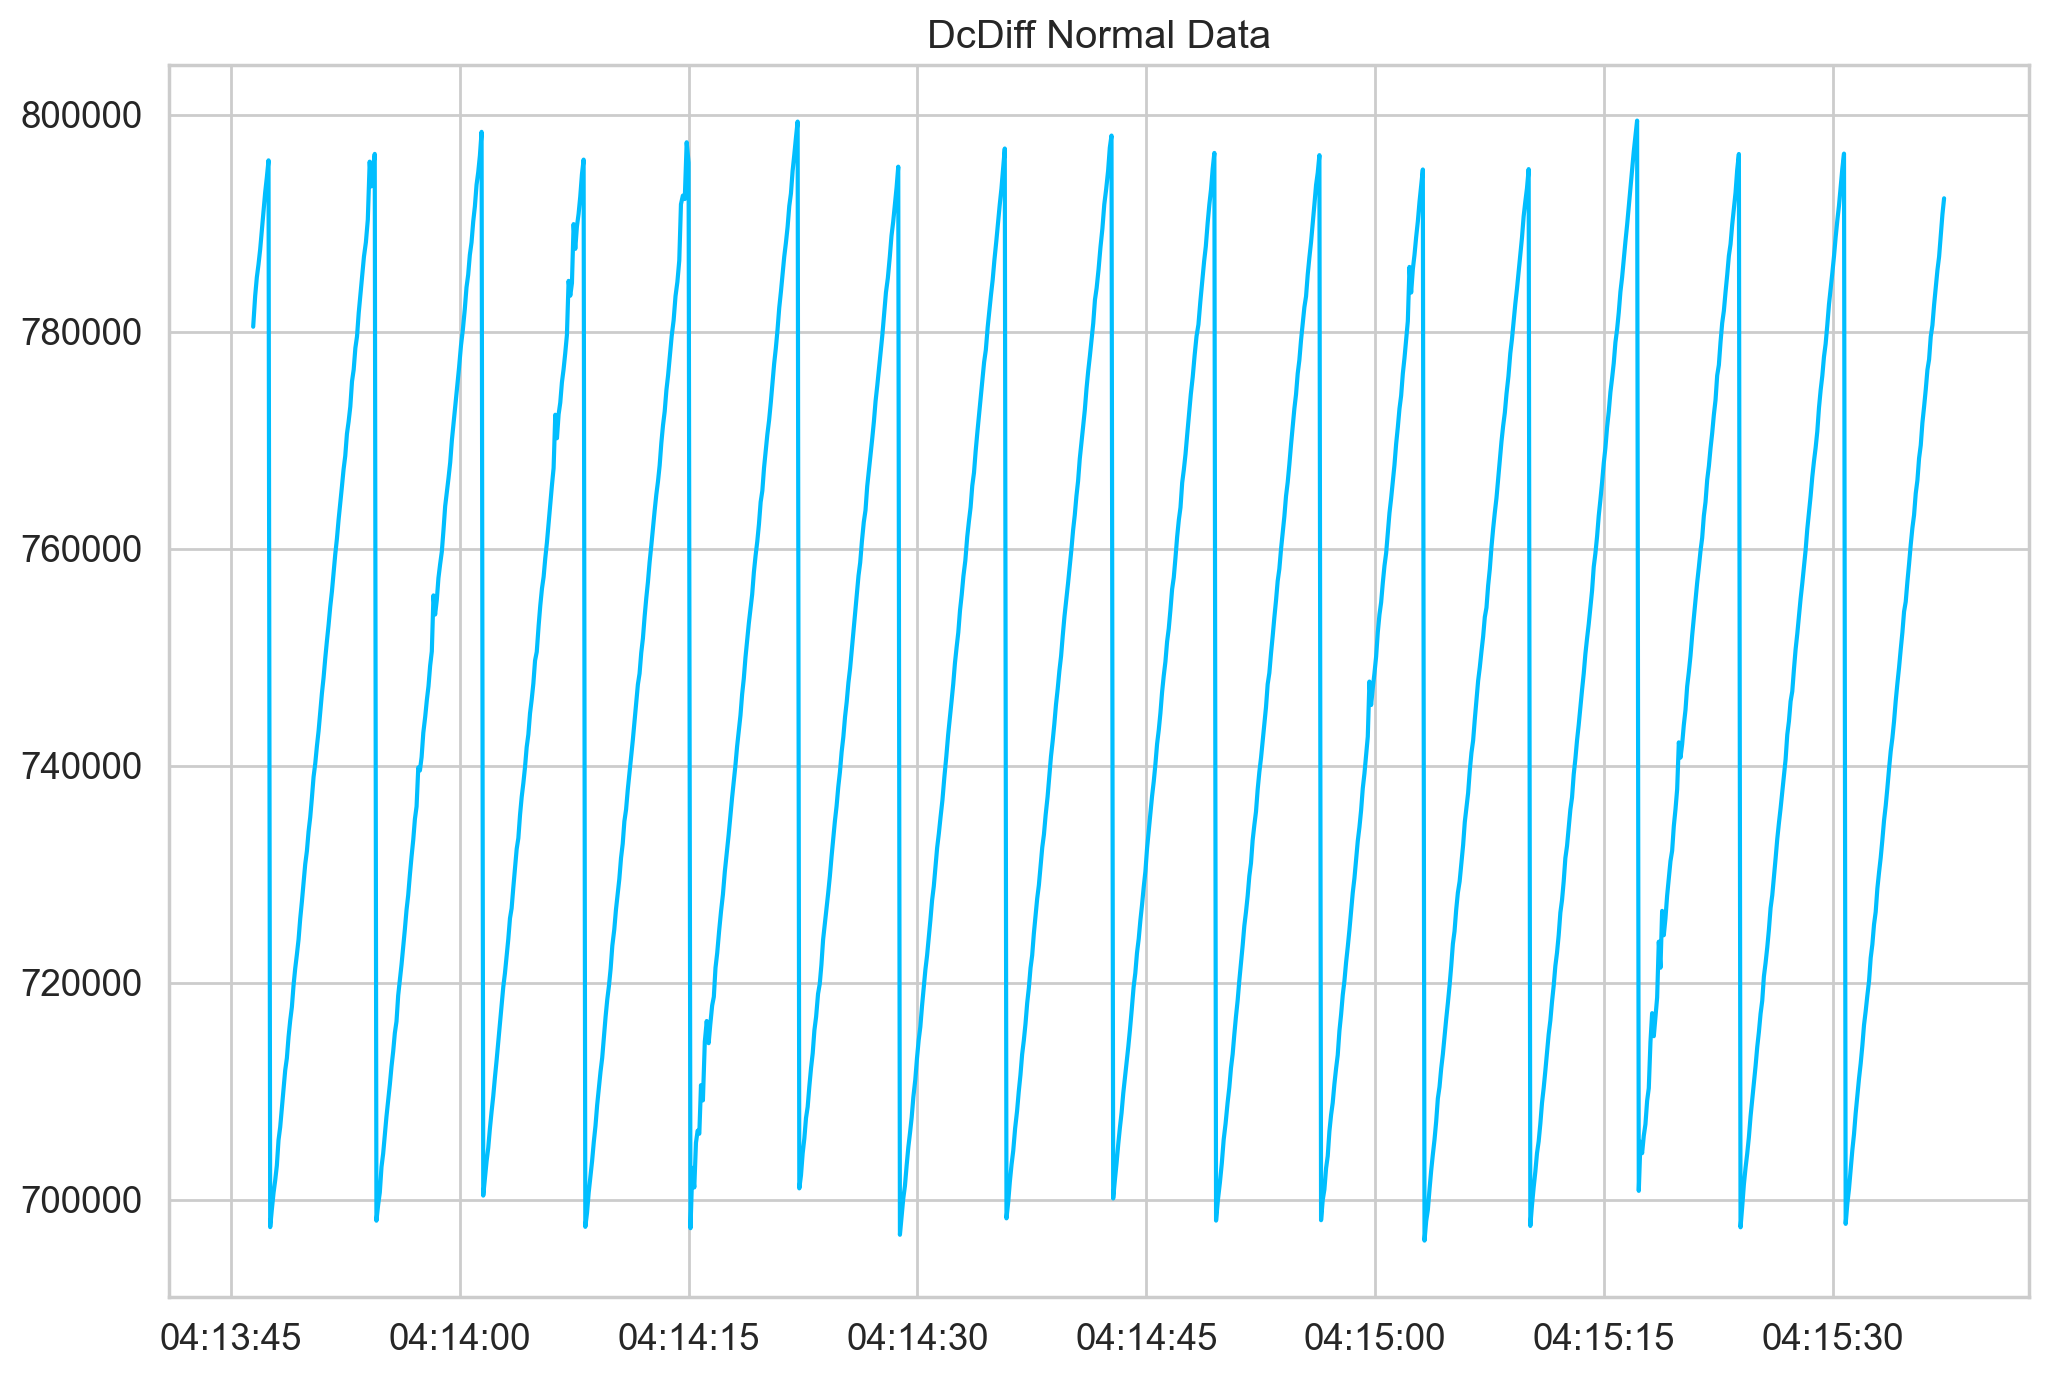

In [139]:
# Plot the current the first 1000 values of downloaded dataframe
hg_df['Timestamp'] = pd.to_datetime(hg_df['Timestamp'])

plt.plot(hg_df['Timestamp'].head(1000), hg_df['DcDiffAvg'].head(1000))
plt.title('DcDiff Normal Data')

# LSTM Autoencoder

## Data preprocessing of the dataset (Normalization)

In [104]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Timestamp', inplace=True)

    for i in range(1, n_steps+1):
        df[f'DcDiffAvg(t-{i})'] = df['DcDiffAvg'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 10
shifted_df = prepare_dataframe_for_lstm(hg_df, lookback)
shifted_df

,DcDiffAvg,DcDiffAvg(t-1),DcDiffAvg(t-2),DcDiffAvg(t-3),DcDiffAvg(t-4),DcDiffAvg(t-5),DcDiffAvg(t-6),DcDiffAvg(t-7),DcDiffAvg(t-8),DcDiffAvg(t-9),DcDiffAvg(t-10)
Timestamp,,,,,,,,,,,
2024-11-01 04:13:47.569243+09:00,697485,795808.0,794250.0,792853.0,791095.0,789378.0,787620.0,786223.0,785026.0,783309.0,780472.0
2024-11-01 04:13:47.678324+09:00,699122,697485.0,795808.0,794250.0,792853.0,791095.0,789378.0,787620.0,786223.0,785026.0,783309.0
2024-11-01 04:13:47.788463+09:00,700640,699122.0,697485.0,795808.0,794250.0,792853.0,791095.0,789378.0,787620.0,786223.0,785026.0
2024-11-01 04:13:47.897157+09:00,701797,700640.0,699122.0,697485.0,795808.0,794250.0,792853.0,791095.0,789378.0,787620.0,786223.0
2024-11-01 04:13:48.005174+09:00,703155,701797.0,700640.0,699122.0,697485.0,795808.0,794250.0,792853.0,791095.0,789378.0,787620.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01 07:18:31.897394+09:00,708195,706358.0,704920.0,703323.0,701805.0,700289.0,698451.0,797093.0,795176.0,794138.0,792382.0
2024-11-01 07:18:32.006663+09:00,709593,708195.0,706358.0,704920.0,703323.0,701805.0,700289.0,698451.0,797093.0,795176.0,794138.0
2024-11-01 07:18:32.115753+09:00,711590,709593.0,708195.0,706358.0,704920.0,703323.0,701805.0,700289.0,698451.0,797093.0,795176.0


In [ ]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

In [106]:
shifted_df_as_np.shape

(100037, 11)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# min~max = -1~1
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

In [108]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

# X is input values and y is target value
X.shape, y.shape

((100037, 10), (100037,))

In [ ]:
# Reverse data to make the recent one last
X = dc(np.flip(X, axis=1))
X

In [110]:
# Split data for train (95%) and test (5%)
split_index = int(len(X) * 0.95)

split_index

95035

In [111]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((95035, 10), (5002, 10), (95035,), (5002,))

In [112]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((95035, 10, 1), (5002, 10, 1), (95035, 1), (5002, 1))

In [113]:
# Make tensors using the train and test data
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([95035, 10, 1]),
 torch.Size([5002, 10, 1]),
 torch.Size([95035, 1]),
 torch.Size([5002, 1]))

In [114]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [115]:
train_dataset

In [116]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [117]:
# See if the shape of batch is appropriate
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 10, 1]) torch.Size([32, 1])


## Building an LSTM Autoencoder

In [118]:
# Declare a class for LSTM neural network
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Create the LSTM variable using input size = 1, hidden size = 4, number of stacked layers = 1 arguments
#model = LSTM(1, 4, 1)
model = LSTM(1, 128, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [119]:
def train_one_epoch(history):
    # Train mode
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    train_losses = []

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            train_losses.append(avg_loss_across_batches)
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()
    history['train'].append(np.mean(train_losses))

In [120]:
def validate_one_epoch(history):
    # Not train mode
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    history['val'].append(avg_loss_across_batches)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

# Training model (or load a pre-trained model later)

In [121]:
learning_rate = 0.00001
num_epochs = 60
loss_function = nn.MSELoss()
#loss_function = nn.L1Loss(reduction='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
history = dict(train=[], val=[])

In [ ]:
# Train and validate
for epoch in range(num_epochs):
    train_one_epoch(history)
    validate_one_epoch(history)

## Plot actual and predicted values

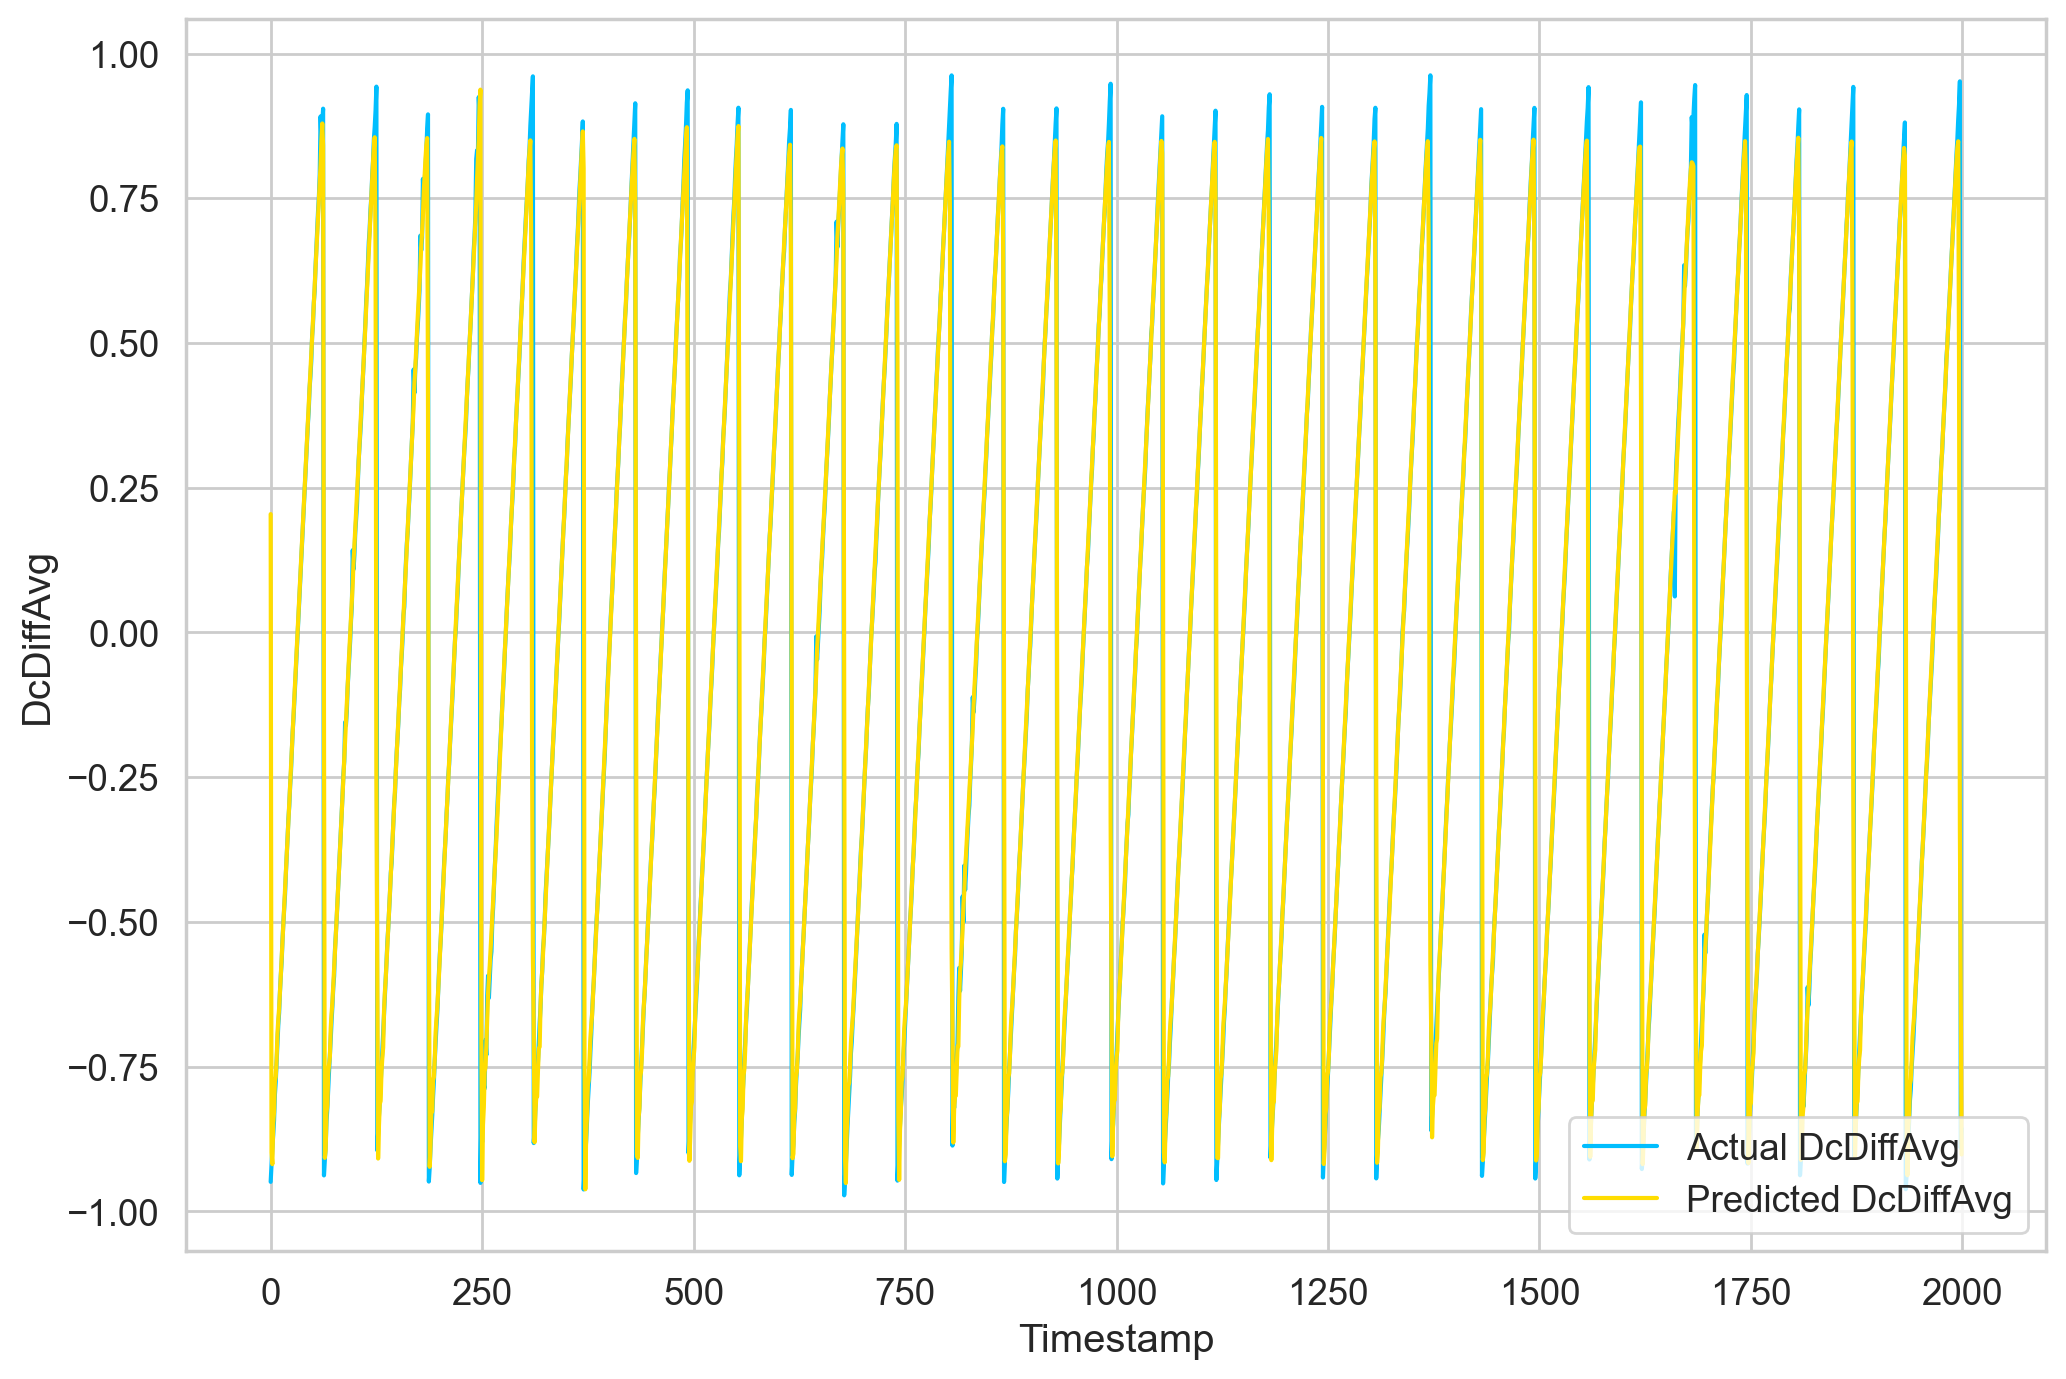

In [123]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train[:2000], label='Actual DcDiffAvg')
plt.plot(predicted[:2000], label='Predicted DcDiffAvg')
plt.xlabel('Timestamp')
plt.ylabel('DcDiffAvg')
plt.legend()
plt.show()

## Loss over training epochs


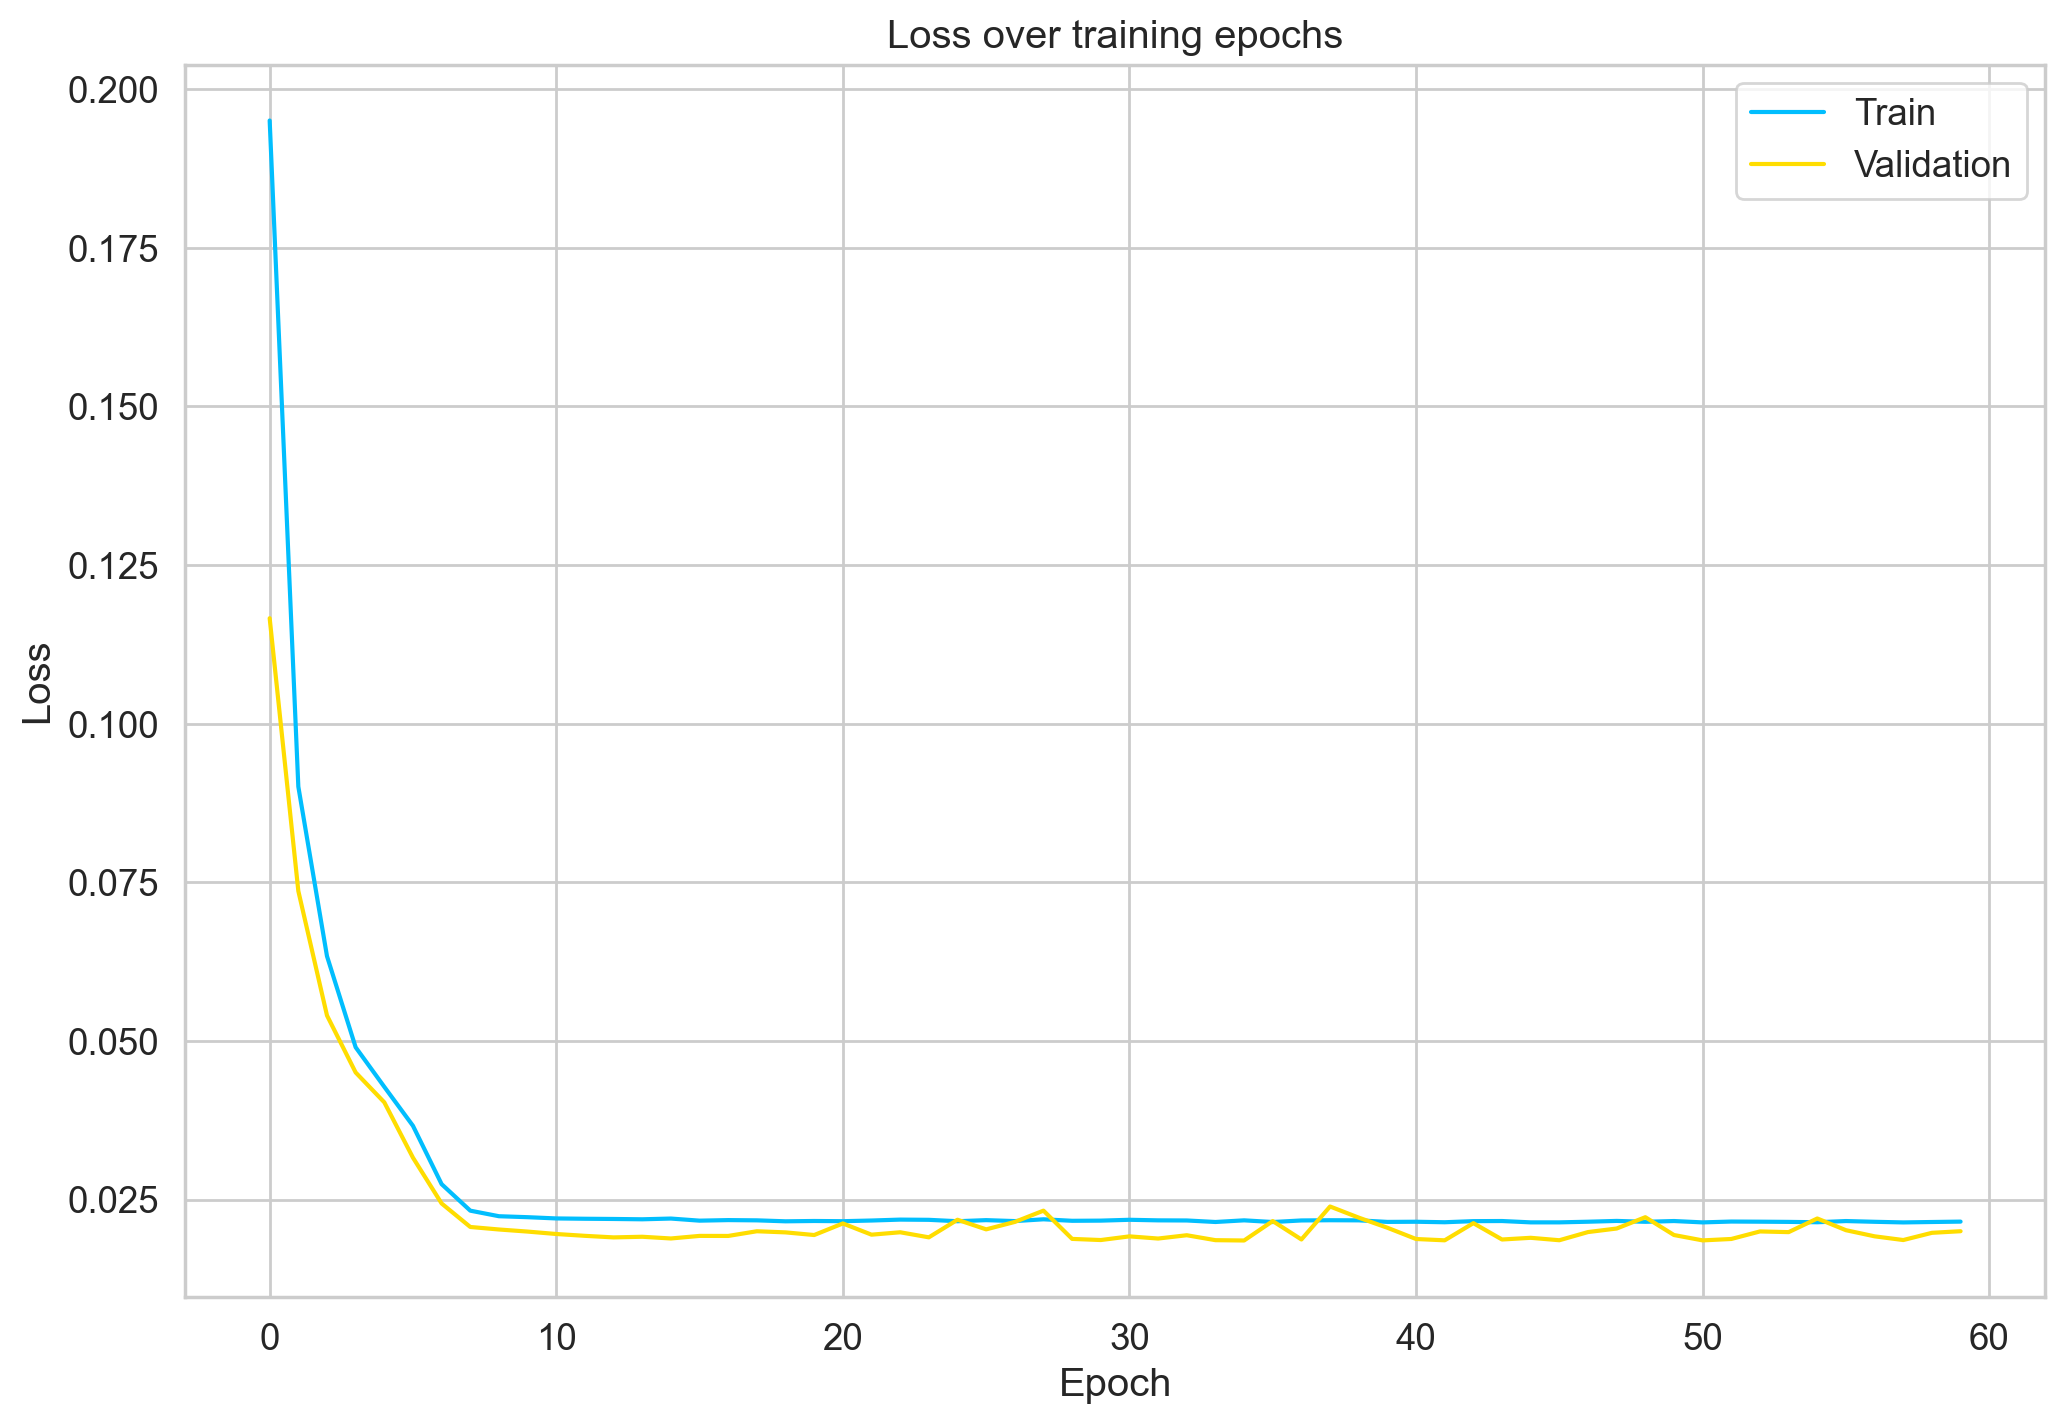

In [124]:
# Plot loss function
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.title('Loss over training epochs')
plt.show();



## Model Assessment

The chart above shows the overall training progress over 60 epochs, demonstrating several key characteristics of the model's performance:

1. Initial Learning Phase
- Training loss (blue line) starts at approximately 0.200
- Validation loss (yellow line) begins around 0.115
- Both losses show rapid decrease in the first 5 epochs
2. Convergence Phase
- Sharp improvement in performance until epoch 10
- Loss values stabilize around 0.025 for both training and validation
- Smooth convergence without major fluctuations
3. Stable Performance
- After epoch 10, both losses maintain consistent values
- Training loss settles slightly above validation loss
- Minimal gap between training and validation indicates good generalization
- No signs of overfitting as validation loss remains stable and below training loss

The model demonstrates healthy learning behavior with quick initial convergence followed by stable performance.


## (Optional) Saving the model for later use

In [125]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

## (Optional) Loading the model for using a pre-trained model

In [ ]:
model = torch.load('model.pth')

model = model.to(device)

## Choosing a threshold

In [127]:
def predict(model, dataset):
  predictions, losses = [], []
  with torch.no_grad():
    model = model.eval()
    for batch_index, batch in enumerate(dataset):
      x_batch, y_batch = batch[0].to(device), batch[1].to(device)

      output = model(x_batch)
      loss = loss_function(output, y_batch)

      predictions.append(output.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

Text(0.5, 1.0, 'Loss histogram of train data')

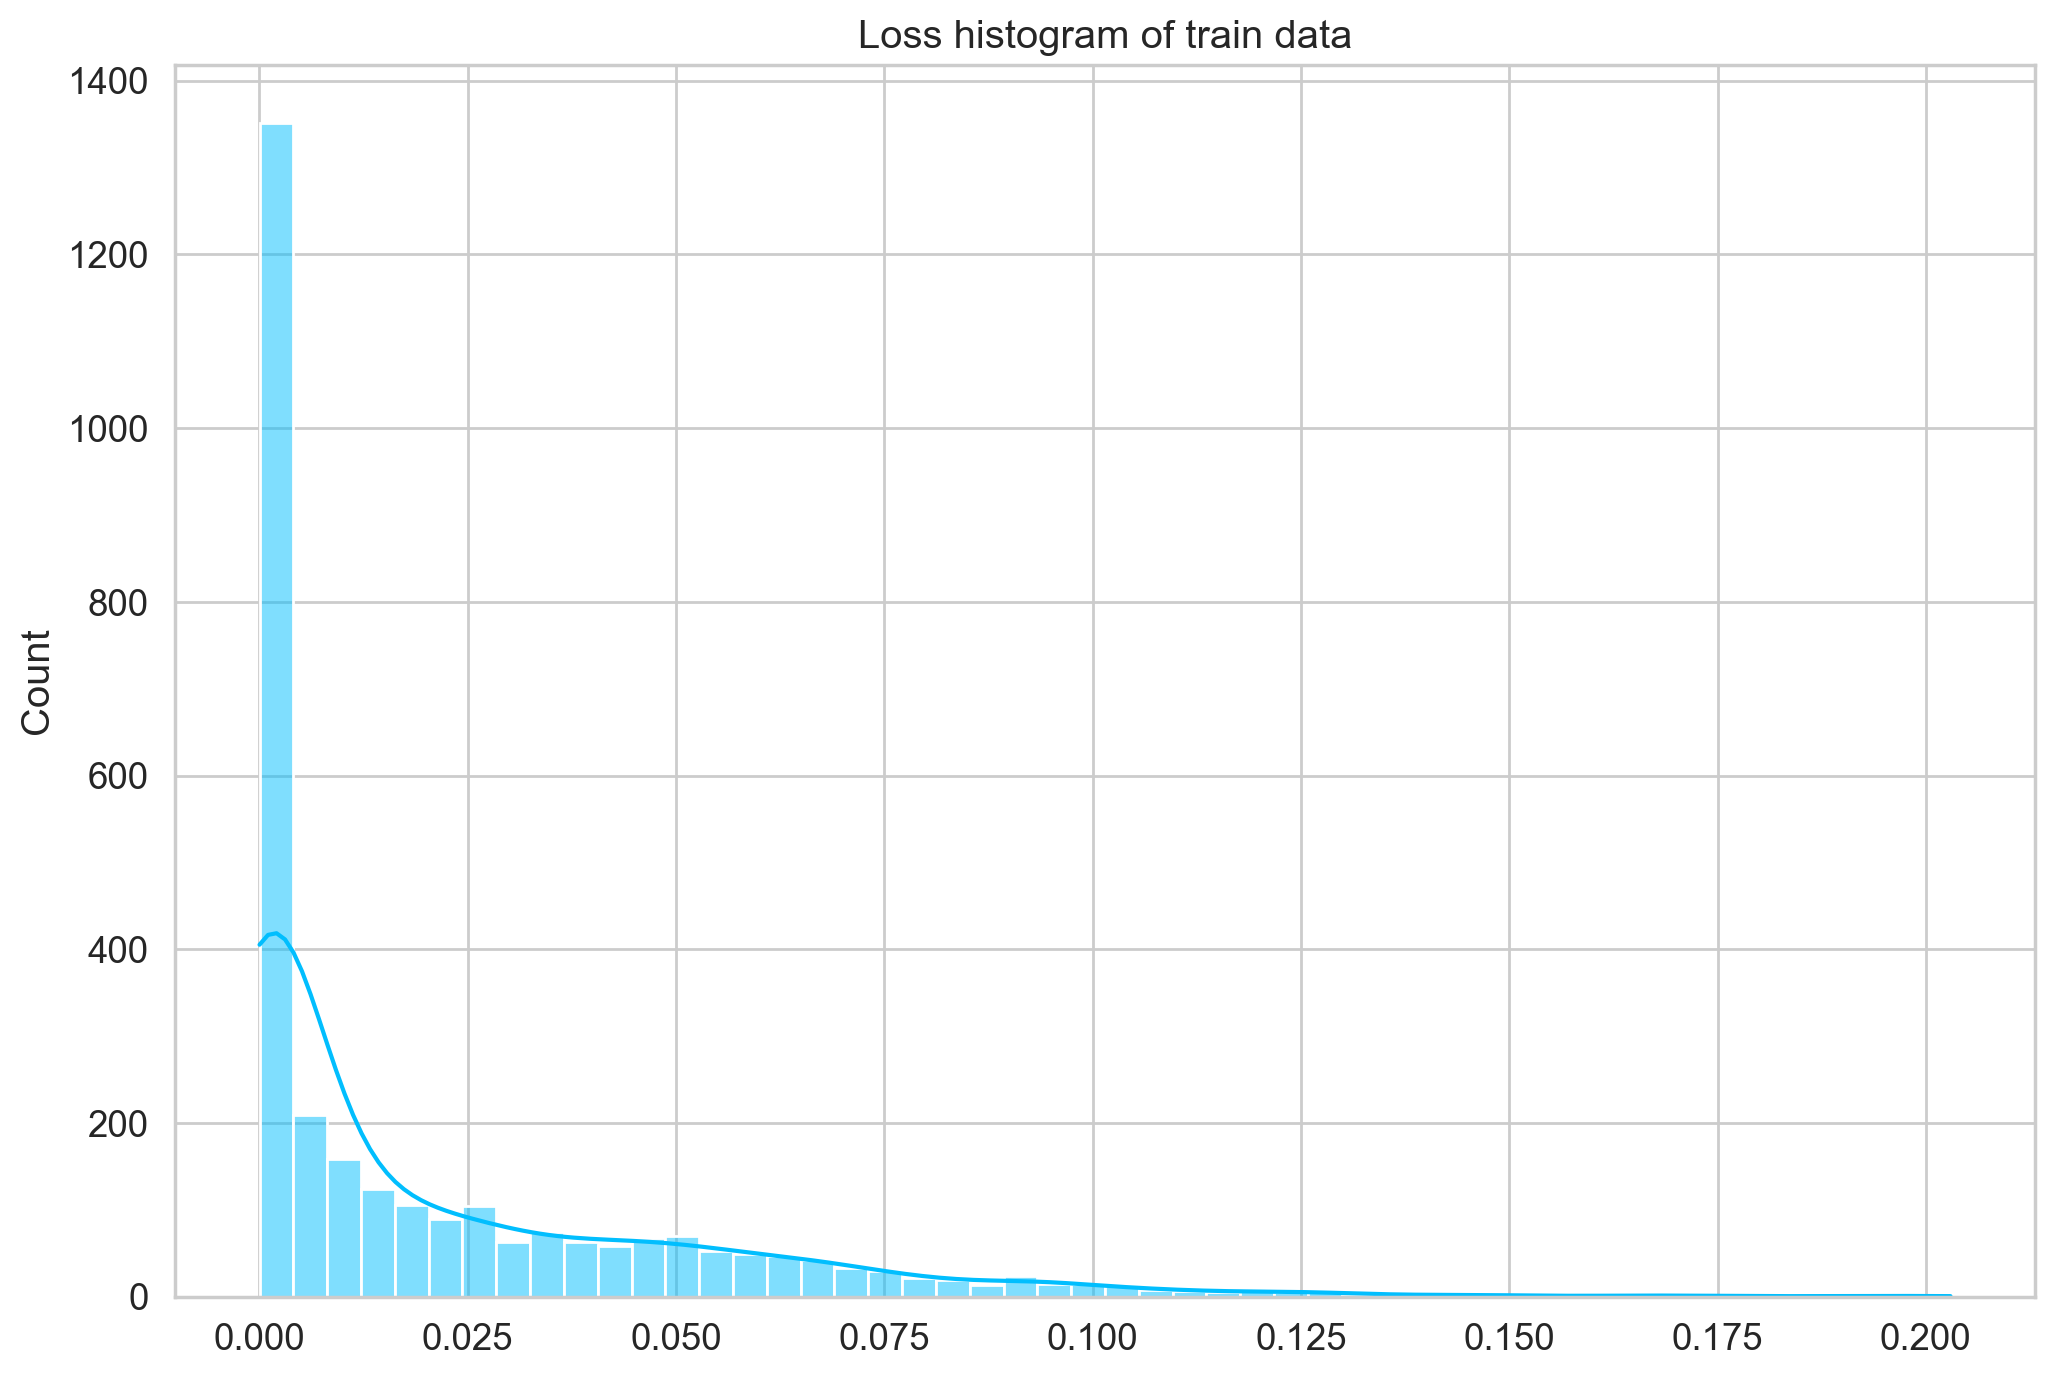

In [128]:
_, losses = predict(model, train_loader)
sns.histplot(losses, bins=50, kde=True).set_title("Loss histogram of train data")

In [140]:
# Choose a threshold by analyzing the loss histogram
THRESHOLD = 0.22

# Evaluation

Using the threshold, we can turn the problem into a simple *binary classification task*:

- If the reconstruction loss is below the threshold, classify it as **normal data**

- Alternatively, if the loss is higher than the threshold, classify it as an **anomaly**

## Normal DC Diff

Text(0.5, 1.0, 'Loss histogram of test data')

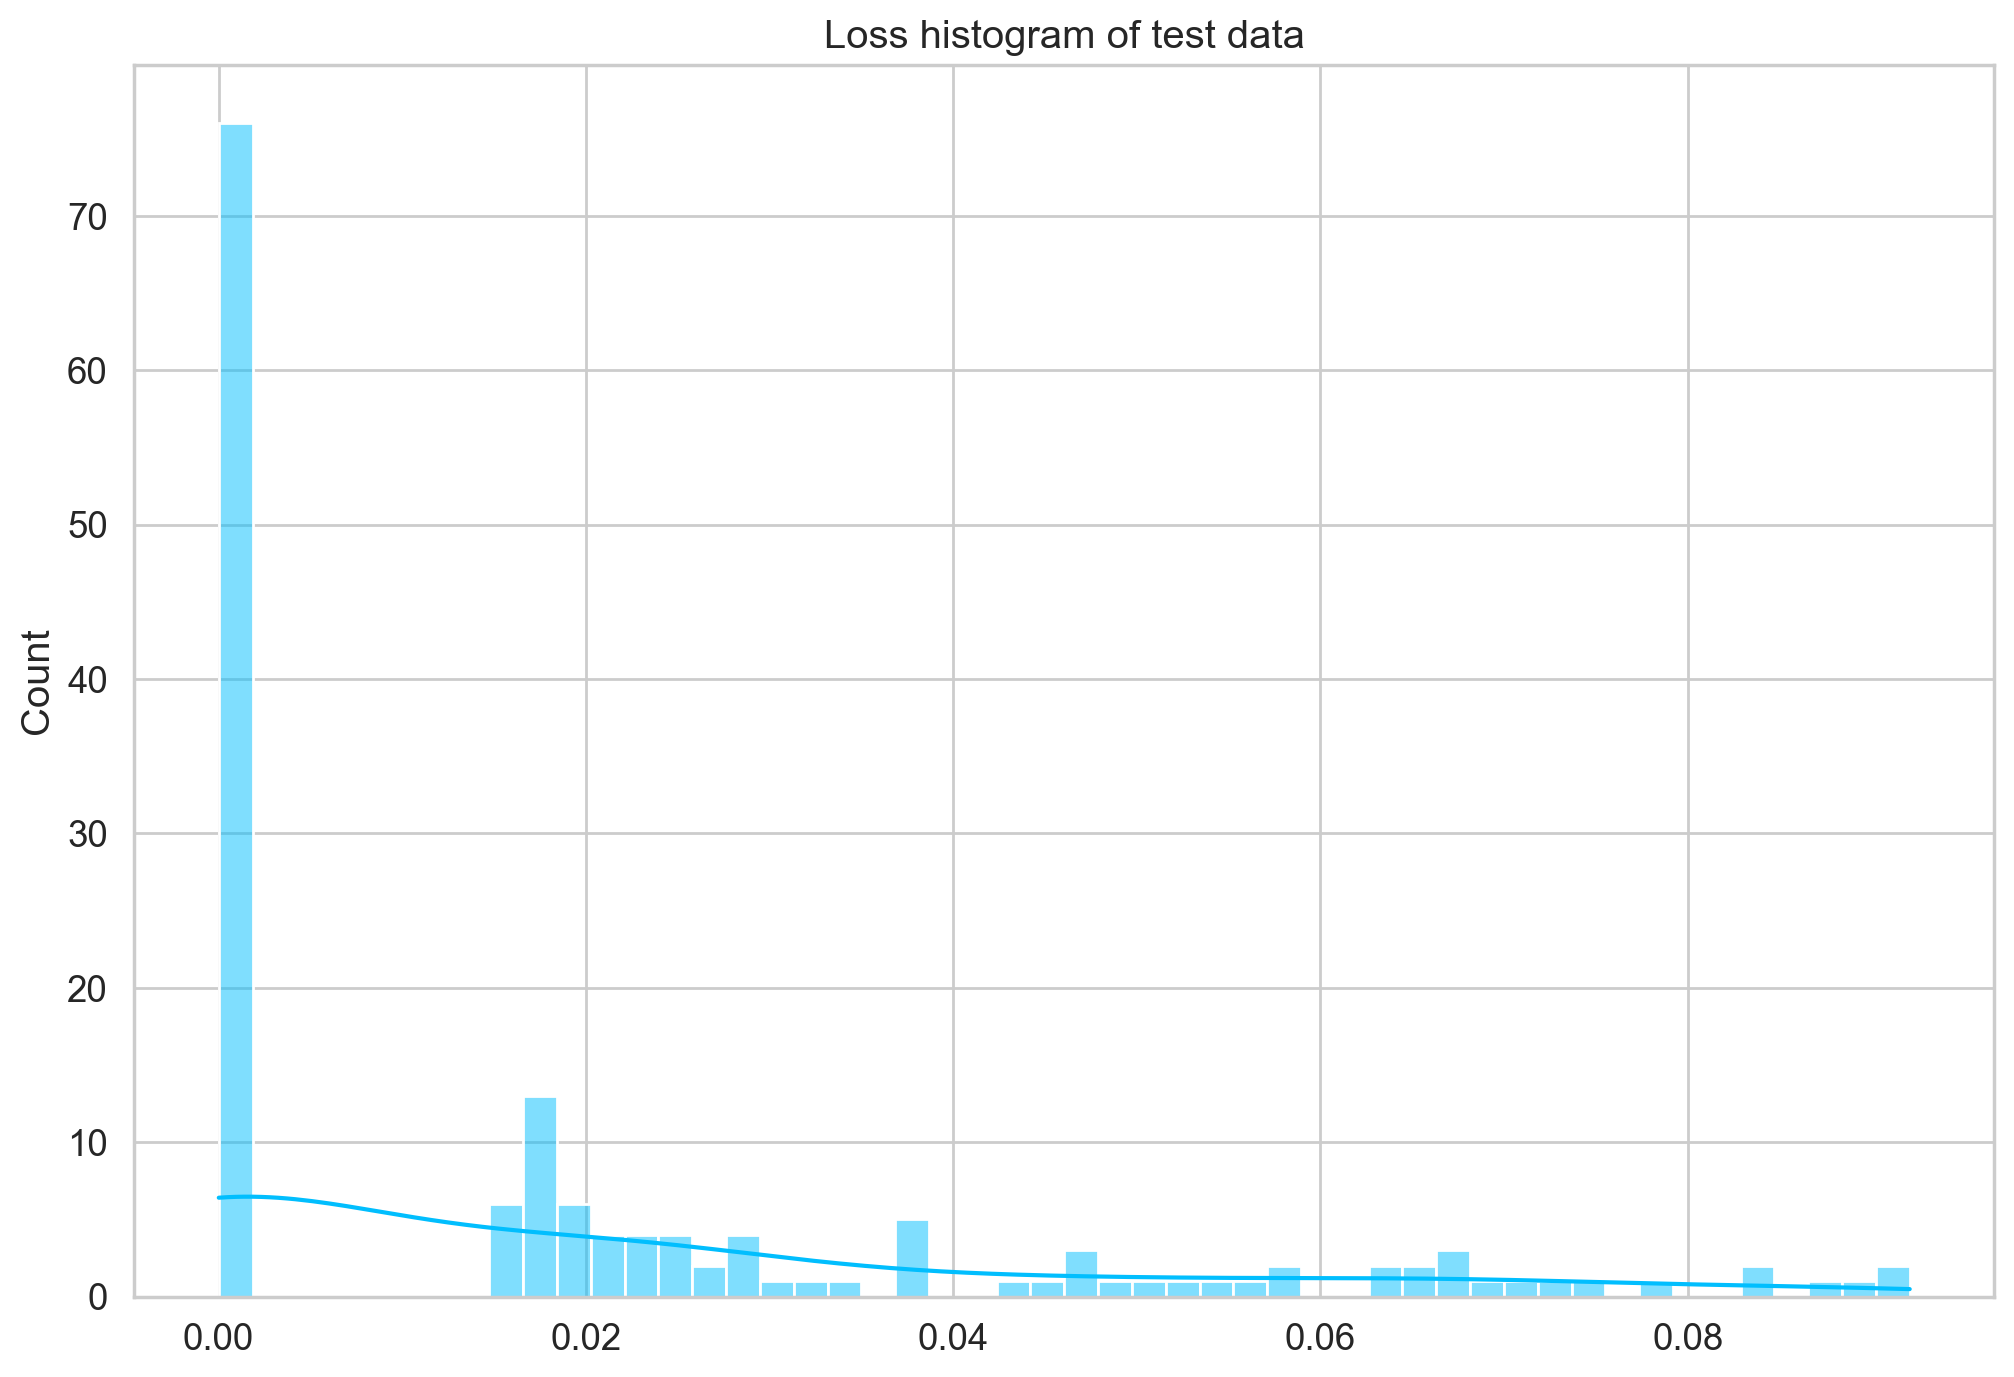

In [141]:
redictions, pred_losses = predict(model, test_loader)
sns.histplot(pred_losses, bins=50, kde=True).set_title("Loss histogram of test data")

In [142]:
correct = sum(l <= THRESHOLD for l in losses)
print(f'Correct normal predictions: {correct}/{len(train_loader)} ({correct*100/len(train_loader)} %)')

Correct normal predictions: 2970/2970 (100.0 %)


### Normal DC Diff evaluation

All the loss values of the normal data are below 0.09 and much lower than the `TREASHOLD` as well, so the correct predictions are **100%**.



## Detecting anomalies

### Download the **abnormal** DC diff dataset from Hugging Face and load the dataset


In [144]:
# Login to the Hugging face
login()

# Load the abnormal dataset
ab_dataset = load_dataset("Jake5/wmx_abnormal_data") 

hg_abdf = pd.DataFrame(ab_dataset['train'])

print(f"Total Values: {hg_abdf.shape[0]}")
print(hg_abdf.head())

Total Values: 28745
                         Timestamp  DcDiffAvg
0 2024-10-11 09:34:03.601191+09:00     726084
1 2024-10-11 09:32:15.179344+09:00     622700
2 2024-10-11 09:32:15.335486+09:00     619999
3 2024-10-11 09:32:15.444917+09:00     618890
4 2024-10-11 09:32:15.553925+09:00     617263


In [145]:
shifted_abdf = prepare_dataframe_for_lstm(hg_abdf, lookback)
shifted_abdf_as_np = shifted_abdf.to_numpy()
shifted_abdf_as_np = scaler.fit_transform(shifted_abdf_as_np)

X_ab = shifted_abdf_as_np[:, 1:]
y_ab = shifted_abdf_as_np[:, 0]

X_ab = X_ab.reshape((-1, lookback, 1))
y_ab = y_ab.reshape((-1, 1))

X_ab = torch.tensor(X_ab).float()
y_ab = torch.tensor(y_ab).float()

abnormal_dataset = TimeSeriesDataset(X_ab, y_ab)
abnormal_loader = DataLoader(abnormal_dataset, batch_size=batch_size, shuffle=False)

Text(0.5, 1.0, 'Loss histogram of abnormal data')

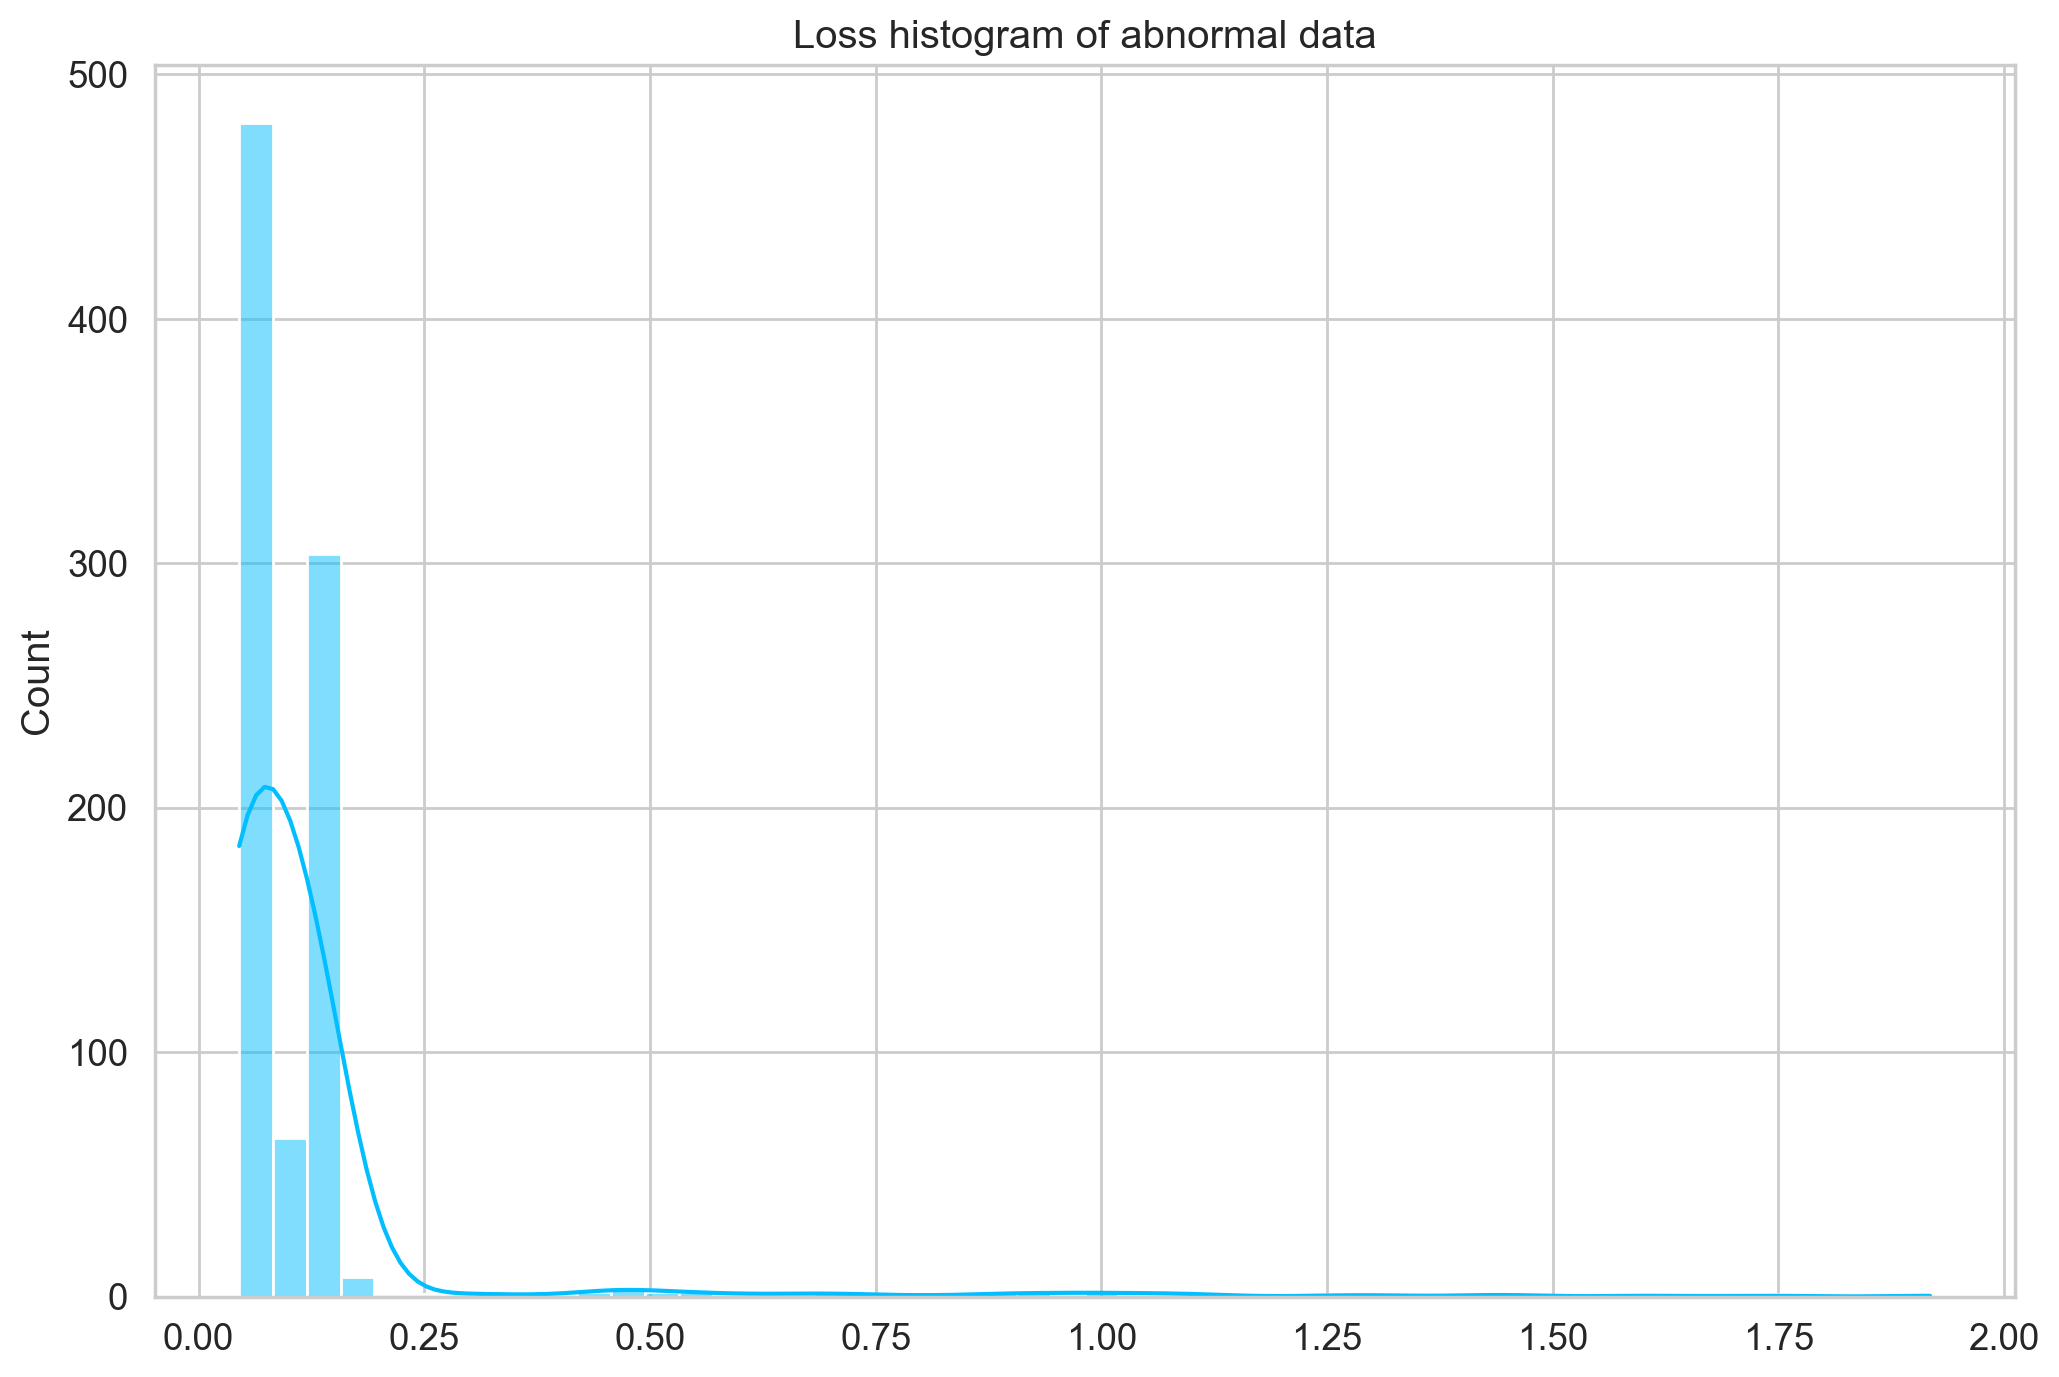

In [146]:
predictions, pred_losses = predict(model, abnormal_loader)
sns.histplot(pred_losses, bins=50, kde=True).set_title("Loss histogram of abnormal data")

In [147]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(abnormal_dataset)} ({correct*100/len(abnormal_dataset)} %)')

Correct anomaly predictions: 40/28735 (0.1392030624673743 %)


### Abnormal DC Diff evaluation

Some loss values of the abnormal data are highe than the `TREASHOLD`, so the number of correct anomaly predictions are **40**.



## Looking at anomalies

In [148]:
flattened_predictions = np.concatenate(predictions)

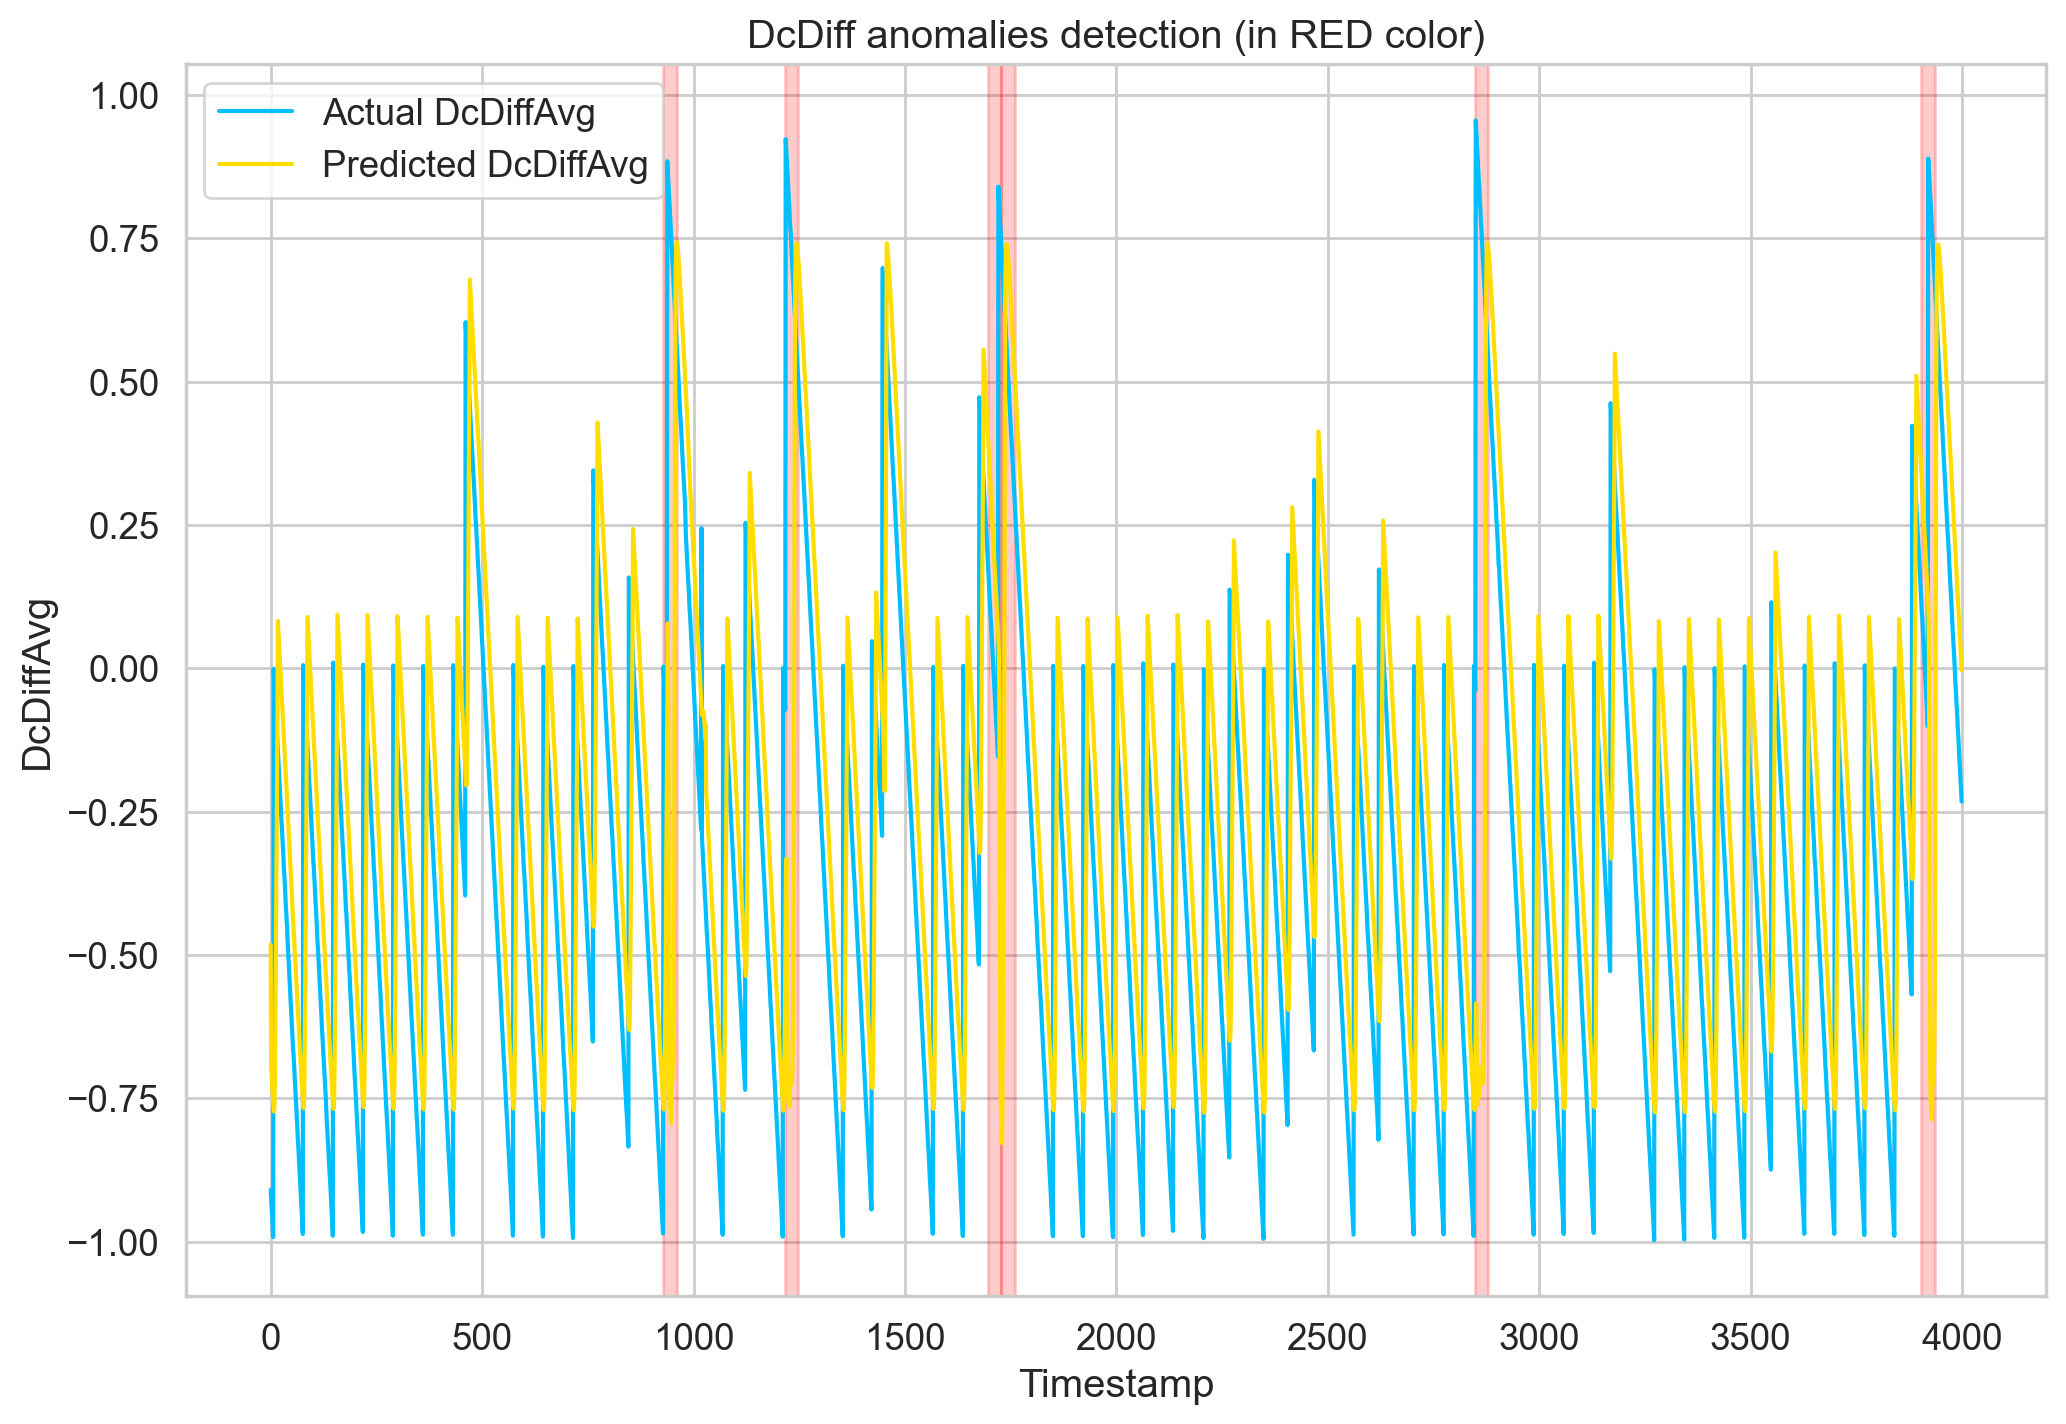

In [154]:
X_LEN = 4000
time_steps = [i for i in range(X_LEN)]

plt.plot(time_steps, y_ab[:X_LEN], label='Actual DcDiffAvg')
plt.plot(time_steps, flattened_predictions[:X_LEN], label='Predicted DcDiffAvg')

batch_ranges = []
    
for idx, loss in enumerate(pred_losses):
    if idx * batch_size > X_LEN:
        break
    if loss > THRESHOLD:
        batch_ranges.append((idx*batch_size, (idx+1)*batch_size))

for start, end in batch_ranges:
    plt.axvspan(start, end, color='red', alpha=0.2)

plt.xlabel('Timestamp')
plt.ylabel('DcDiffAvg')
plt.title('DcDiff anomalies detection (in RED color)')
plt.legend()
plt.show()

## Prediction Performance with Anomalies

### Anomaly Characteristics:
Red vertical bands indicate timestamps where prediction errors exceed the threshold.

Anomalies primarily occur during:
- Sudden spike transitions (around timestamp 1000, 1500)
- Extreme value regions (near peaks and troughs)
- Rapid value changes (around timestamp 2500, 3500)

Pattern Analysis:
- Anomalies are more frequent during volatile periods
- Regular patterns show fewer anomalies
- Clusters of anomalies appear during high-amplitude transitions
- Most stable predictions occur during gradual changes

_**The anomaly detection effectively identifies periods where the model's predictions deviate significantly from actual values, particularly during rapid or extreme changes in the time series.**_



## Remaining Considerations

- Some validation volatility still exists, though significantly reduced

- The training loss could potentially benefit from further fine-tuning to achieve even smoother convergence

- The model might benefit from a longer training period to see if the trend continues to improve

# References

- [Time Series Anomaly Detection Tutorial with PyTorch in Python | LSTM Autoencoder for ECG Data](https://www.youtube.com/watch?v=qN3n0TM4Jno)
- [Amazon Stock Forecasting in PyTorch with LSTM Neural Network (Time Series Forecasting) | Tutorial 3](https://www.youtube.com/watch?v=q_HS4s1L8UI&t=5s)
- [\[NHN Cloud make IT 2023\] 시계열 데이터 속에 숨어있는 이상 징후를 찾는 딥 러닝 기술](https://www.youtube.com/watch?v=bg2e60IZ40Q)
